# Тема “Feature Engineering, Feature Selection, part I.”


<hr>
<b>Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).
<hr>
Задания:
<ol>
<li><a href="#task_0">Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.
</a>
<li><a href = "#task_1">Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.
</a>
<li><a href = "#task_2">Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.
</a>
<li><a href = "#task_3">Задание 3: использовать permutation importance, выполнить задание 1 и 2.
</a>
<li><a href = "#task_4">Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.
</a>
<li><a href = "#task_5">Задание 5: использовать shap, выполнить задание 1 и 2.
</a>
<li><a href = "#task_6">Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.
</a>
</ol>

## Импорт библиотек

In [1]:
import warnings

import lightgbm as lgbm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.metrics import (f1_score, roc_auc_score,
                             precision_score, classification_report,
                             precision_recall_curve, confusion_matrix)
from sklearn.model_selection import  train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import LabelEncoder

warnings.simplefilter("ignore")
pd.options.display.max_columns = 500
%matplotlib inline

In [2]:
def optimization_memory_usage(df: pd.DataFrame):
    """ 
    Функция оптимизации числовых значений по int[8, 16, 32, 64] по float[16, 32, 64]
    с преобразованием object -> category
    """
    start_memory_usage = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_memory_usage:.2f} MB')
    
    for column in df.columns:
        column_type = df[column].dtype
        
        if column_type != object: 
            col_min = df[column].min()
            col_max = df[column].max()
            if str(column_type)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)

                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)

                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)

                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64) 
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[column] = df[column].astype(np.float16)

                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)

                else:
                    df[column] = df[column].astype(np.float64)
        else:
            df[column] = df[column].astype('category')
            
    end_memory_usage = df.memory_usage().sum() / 1024**2
    percent_optimization  = 100 * (start_memory_usage - end_memory_usage) / start_memory_usage
    print(f'Memory usage after optimization is: {end_memory_usage:.2f} MB')
    print(f'Decreased by {percent_optimization:.1f}%')
    
    return df


def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result.T


def run_model(train_data: pd.DataFrame,
              train_target: pd.Series,
              test_data: pd.DataFrame,
              test_target: pd.Series,
              cv: int =5, fscore_b:int = 1,
              model = lgbm.LGBMClassifier,
              params_lgbm:dict = {"boosting_type": "gbdt",
                                  "objective": "binary",
                                  "metric": "auc",
                                  "learning_rate": 0.1,
                                  "n_estimators": 1000,
                                  #"categorical_feature":"auto",
                                  "n_jobs": -1,
                                  "seed": 21
                                 }) -> dict:
    
    from sklearn.metrics import f1_score
    from sklearn.metrics import roc_auc_score
    
    X_train, X_valid = train_test_split(train_data,
                                        train_size=0.7,
                                        shuffle=True,
                                        random_state=21)

    y_train, y_valid = train_test_split(train_target,
                                        train_size=0.7,
                                        shuffle=True,
                                        random_state=21)

    classifier = model(**params_lgbm)  
    
    classifier.fit(X=X_train, y=y_train,
                  eval_set=[(X_train, y_train),
                            (X_valid, y_valid)
                           ],
                  early_stopping_rounds=100,
                  eval_metric="auc",
                  verbose=100)
    
    #запустим кросс-валидацию на всей тренировочной выборке
    cv_scores = cross_val_score(classifier,
                                train_data,
                                train_target,
                                cv=cv,
                                scoring='roc_auc')
    
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    cv_result = f'{round(cv_score, 4)} +/- {round(cv_score_std, 3)}'
    
    # valid scores
    y_valscore = classifier.predict_proba(X_valid)[:, 1]
    
    # Precision, Recall, F_score, Roc auc
    precision_val, recall_val, thresholds_val = precision_recall_curve(y_valid.values, y_valscore)
    fscore_val = (1 + fscore_b**2) * (precision_val * recall_val) / (fscore_b**2 * precision_val + recall_val)
    roc_auc_val = roc_auc_score(y_valid, y_valscore)
    ix_val = np.argmax(fscore_val)
    
    # test scores
    y_score = classifier.predict_proba(test_data)[:, 1]
    
    # Precision, Recall, F_score, Roc auc
    precision, recall, thresholds = precision_recall_curve(test_target.values, y_score)
    fscore = (1 + fscore_b**2) * (precision * recall) / (fscore_b**2 * precision + recall)
    roc_auc = roc_auc_score(test_target, y_score)
    ix = np.argmax(fscore)
    
    res_score = {
        'cv_results': [cv_result],
        'roc_auc(valid, test)': [roc_auc_val, roc_auc],
        'precision(valid, test)': [precision_val[ix_val], precision[ix]],
        'recall(valid, test)': [recall_val[ix_val], recall[ix]],
        'fscore(valid, test)': [fscore_val[ix_val], fscore[ix]],
    } 
    
    return classifier, res_score

## Загрузка данных

In [3]:
target = 'isFraud'

train_data = pd.read_csv('../Lesson5:FeatureEngineering,FeatureSelection,partI/train_data_feature_eng.csv').drop("Unnamed: 0", axis=1).drop(columns = ['TransactionID'])
train_target = pd.read_csv('../Lesson5:FeatureEngineering,FeatureSelection,partI/train_target_feature_eng.csv').drop("Unnamed: 0", axis=1)


test_data = pd.read_csv('../Lesson5:FeatureEngineering,FeatureSelection,partI/test_data_feature_eng.csv').drop("Unnamed: 0", axis=1).drop(columns = ['TransactionID'])
test_target = pd.read_csv('../Lesson5:FeatureEngineering,FeatureSelection,partI/test_target_feature_eng.csv').drop("Unnamed: 0", axis=1)


In [4]:
train_data = optimization_memory_usage(train_data)

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 177.65 MB
Decreased by 71.6%


In [5]:
train_target = optimization_memory_usage(train_target)

Memory usage of dataframe is 1.37 MB
Memory usage after optimization is: 0.17 MB
Decreased by 87.5%


In [6]:
test_data = optimization_memory_usage(test_data)

Memory usage of dataframe is 347.14 MB
Memory usage after optimization is: 95.09 MB
Decreased by 72.6%


In [7]:
test_target = optimization_memory_usage(test_target)

Memory usage of dataframe is 0.76 MB
Memory usage after optimization is: 0.10 MB
Decreased by 87.5%


In [8]:
X_train, X_valid = train_test_split(train_data,
                                    train_size=0.7,
                                    shuffle=True,
                                    random_state=21)

y_train, y_valid = train_test_split(train_target,
                                    train_size=0.7,
                                    shuffle=True,
                                    random_state=21)

number_feature_df = train_data.select_dtypes(include=[np.number])
object_feature_df = train_data.select_dtypes(exclude=[np.number])





In [9]:
train_data.head(3)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,transaction_year,transaction_month,transaction_day,transaction_hour,transaction_day_of_week,card12,card1235,card1235_addr12,card1_freq,card2_freq,card3_freq,card4_freq,card5_freq,card6_freq,addr1_freq,addr2_freq,TransactionAmt_/_meanTransactionAmtBy_card1,TransactionAmt_/_meanTransactionAmtBy_card2,TransactionAmt_/_meanTransactionAmtBy_card3,TransactionAmt_/_meanTransactionAmtBy_card4,TransactionAmt_/_meanTransactionAmtBy_card5,TransactionAmt_/_meanTransactionAmtBy_card6,TransactionAmt_/_meanTransactionAmtBy_addr1,TransactionAmt_/_meanTransactionAmtBy_addr2,TransactionAmt_/_meanTransactionAmtBy_card12,TransactionAmt_/_meanTransactionAmtBy_card1235,TransactionAmt_/_meanTransactionAmtBy_card1235_addr12,TransactionAmt_/_stdTransactionAmtBy_card1,TransactionAmt_/_stdTransactionAmtBy_card2,TransactionAmt_/_stdTransactionAmtBy_card3,TransactionAmt_/_stdTransactionAmtBy_card4,TransactionAmt_/_stdTransactionAmtBy_card5,TransactionAmt_/_stdTransactionAmtBy_card6,TransactionAmt_/_stdTransactionAmtBy_addr1,TransactionAmt_/_stdTransactionAmtBy_addr2,TransactionAmt_/_stdTransactionAmtBy_card12,TransactionAmt_/_stdTransactionAmtBy_card1235,TransactionAmt_/_stdTransactionAmtBy_card1235_addr12,D15_/_meanD15By_card1,D15_/_meanD15By_card2,D15_/_meanD15By_card3,D15_/_meanD15By_card4,D15_/_meanD15By_card5,D15_/_meanD15By_card6,D15_/_meanD15By_addr1,D15_/_meanD15By_addr2,D15_/_meanD15By_card12,D15_/_meanD15By_card1235,D15_/_meanD15By_card1235_addr12,D15_/_stdD15By_card1,D15_/_stdD15By_card2,D15_/_stdD15By_card3,D15_/_stdD15By_card4,D15_/_stdD15By_card5,D15_/_stdD15By_card6,D15_/_stdD15By_addr1,D15_/_stdD15By_addr2,D15_/_stdD15By_card12,D15_/_stdD15By_card1235,D15_/_stdD15By_card1235_addr12,TransactionAmt_int,TransactionAmt_frac,TransactionAmt_log
0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

## Выполнение заданий

In [10]:
train_missing = check_missings(train_data)
train_missing

Total NA-values = 29531491


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,transaction_year,transaction_month,transaction_day,transaction_hour,transaction_day_of_week,card12,card1235,card1235_addr12,card1_freq,card2_freq,card3_freq,card4_freq,card5_freq,card6_freq,addr1_freq,addr2_freq,TransactionAmt_/_meanTransactionAmtBy_card1,TransactionAmt_/_meanTransactionAmtBy_card2,TransactionAmt_/_meanTransactionAmtBy_card3,TransactionAmt_/_meanTransactionAmtBy_card4,TransactionAmt_/_meanTransactionAmtBy_card5,TransactionAmt_/_meanTransactionAmtBy_card6,TransactionAmt_/_meanTransactionAmtBy_addr1,TransactionAmt_/_meanTransactionAmtBy_addr2,TransactionAmt_/_meanTransactionAmtBy_card12,TransactionAmt_/_meanTransactionAmtBy_card1235,TransactionAmt_/_meanTransactionAmtBy_card1235_addr12,TransactionAmt_/_stdTransactionAmtBy_card1,TransactionAmt_/_stdTransactionAmtBy_card2,TransactionAmt_/_stdTransactionAmtBy_card3,TransactionAmt_/_stdTransactionAmtBy_card4,TransactionAmt_/_stdTransactionAmtBy_card5,TransactionAmt_/_stdTransactionAmtBy_card6,TransactionAmt_/_stdTransactionAmtBy_addr1,TransactionAmt_/_stdTransactionAmtBy_addr2,TransactionAmt_/_stdTransactionAmtBy_card12,TransactionAmt_/_stdTransactionAmtBy_card1235,TransactionAmt_/_stdTransactionAmtBy_card1235_addr12,D15_/_meanD15By_card1,D15_/_meanD15By_card2,D15_/_meanD15By_card3,D15_/_meanD15By_card4,D15_/_meanD15By_card5,D15_/_meanD15By_card6,D15_/_meanD15By_addr1,D15_/_meanD15By_addr2,D15_/_meanD15By_card12,D15_/_meanD15By_card1235,D15_/_meanD15By_card1235_addr12,D15_/_stdD15By_card1,D15_/_stdD15By_card2,D15_/_stdD15By_card3,D15_/_stdD15By_card4,D15_/_stdD15By_card5,D15_/_stdD15By_card6,D15_/_stdD15By_addr1,D15_/_stdD15By_addr2,D15_/_stdD15By_card12,D15_/_stdD15By_card1235,D15_/_stdD15By_card1235_addr12,TransactionAmt_int,TransactionAmt_frac,TransactionAmt_log
Total,0,0,0,0,2611,3,8,953,7,19433,19433,119395,165542,28440,119700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99698,96962,73073,111244,155764,168324,146404,146404,45665,120901,159196,161333,159456,48819,118251,118251,118251,96724,118297,74348,148348,148348,148348,120901,120901,120901,120901,120901,120901,120901,120901,120901,120901,120901,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,456

In [11]:
test_missing = check_missings(test_data)
test_missing

Total NA-values = 16787436


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,transaction_year,transaction_month,transaction_day,transaction_hour,transaction_day_of_week,card12,card1235,card1235_addr12,card1_freq,card2_freq,card3_freq,card4_freq,card5_freq,card6_freq,addr1_freq,addr2_freq,TransactionAmt_/_meanTransactionAmtBy_card1,TransactionAmt_/_meanTransactionAmtBy_card2,TransactionAmt_/_meanTransactionAmtBy_card3,TransactionAmt_/_meanTransactionAmtBy_card4,TransactionAmt_/_meanTransactionAmtBy_card5,TransactionAmt_/_meanTransactionAmtBy_card6,TransactionAmt_/_meanTransactionAmtBy_addr1,TransactionAmt_/_meanTransactionAmtBy_addr2,TransactionAmt_/_meanTransactionAmtBy_card12,TransactionAmt_/_meanTransactionAmtBy_card1235,TransactionAmt_/_meanTransactionAmtBy_card1235_addr12,TransactionAmt_/_stdTransactionAmtBy_card1,TransactionAmt_/_stdTransactionAmtBy_card2,TransactionAmt_/_stdTransactionAmtBy_card3,TransactionAmt_/_stdTransactionAmtBy_card4,TransactionAmt_/_stdTransactionAmtBy_card5,TransactionAmt_/_stdTransactionAmtBy_card6,TransactionAmt_/_stdTransactionAmtBy_addr1,TransactionAmt_/_stdTransactionAmtBy_addr2,TransactionAmt_/_stdTransactionAmtBy_card12,TransactionAmt_/_stdTransactionAmtBy_card1235,TransactionAmt_/_stdTransactionAmtBy_card1235_addr12,D15_/_meanD15By_card1,D15_/_meanD15By_card2,D15_/_meanD15By_card3,D15_/_meanD15By_card4,D15_/_meanD15By_card5,D15_/_meanD15By_card6,D15_/_meanD15By_addr1,D15_/_meanD15By_addr2,D15_/_meanD15By_card12,D15_/_meanD15By_card1235,D15_/_meanD15By_card1235_addr12,D15_/_stdD15By_card1,D15_/_stdD15By_card2,D15_/_stdD15By_card3,D15_/_stdD15By_card4,D15_/_stdD15By_card5,D15_/_stdD15By_card6,D15_/_stdD15By_addr1,D15_/_stdD15By_addr2,D15_/_stdD15By_card12,D15_/_stdD15By_card1235,D15_/_stdD15By_card1235_addr12,TransactionAmt_int,TransactionAmt_frac,TransactionAmt_log
Total,0,0,0,0,1676,816,817,1300,817,11701,11701,60898,95641,15471,83405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,269,46526,42466,20701,48633,88936,93939,90543,90543,6037,33039,89685,89285,89702,9319,32615,32615,32615,45296,56419,23003,43319,43316,43316,33039,33039,33039,33039,33039,33039,33039,33039,33039,33039,33039,6042,6042,6042,6042,6042,6042,6042,6042,6042,6042,6042,6042,6042,6042,6042,6042,6042,6042,6042,604

<p><a name="task_0"></a></p>

### Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.


In [12]:
model, res_0 = run_model(train_data, train_target, test_data, test_target)
res_0

[100]	training's auc: 0.997147	valid_1's auc: 0.953241
[200]	training's auc: 0.999753	valid_1's auc: 0.956607
[300]	training's auc: 0.999989	valid_1's auc: 0.956852


{'cv_results': ['0.802 +/- 0.159'],
 'roc_auc(valid, test)': [0.9570653164634257, 0.8272922256550146],
 'precision(valid, test)': [0.8875404530744336, 0.5481751824817518],
 'recall(valid, test)': [0.7179319371727748, 0.39484752891692954],
 'fscore(valid, test)': [0.7937771345875542, 0.45904645476772615]}

<p><a name="task_1"></a></p>

### Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

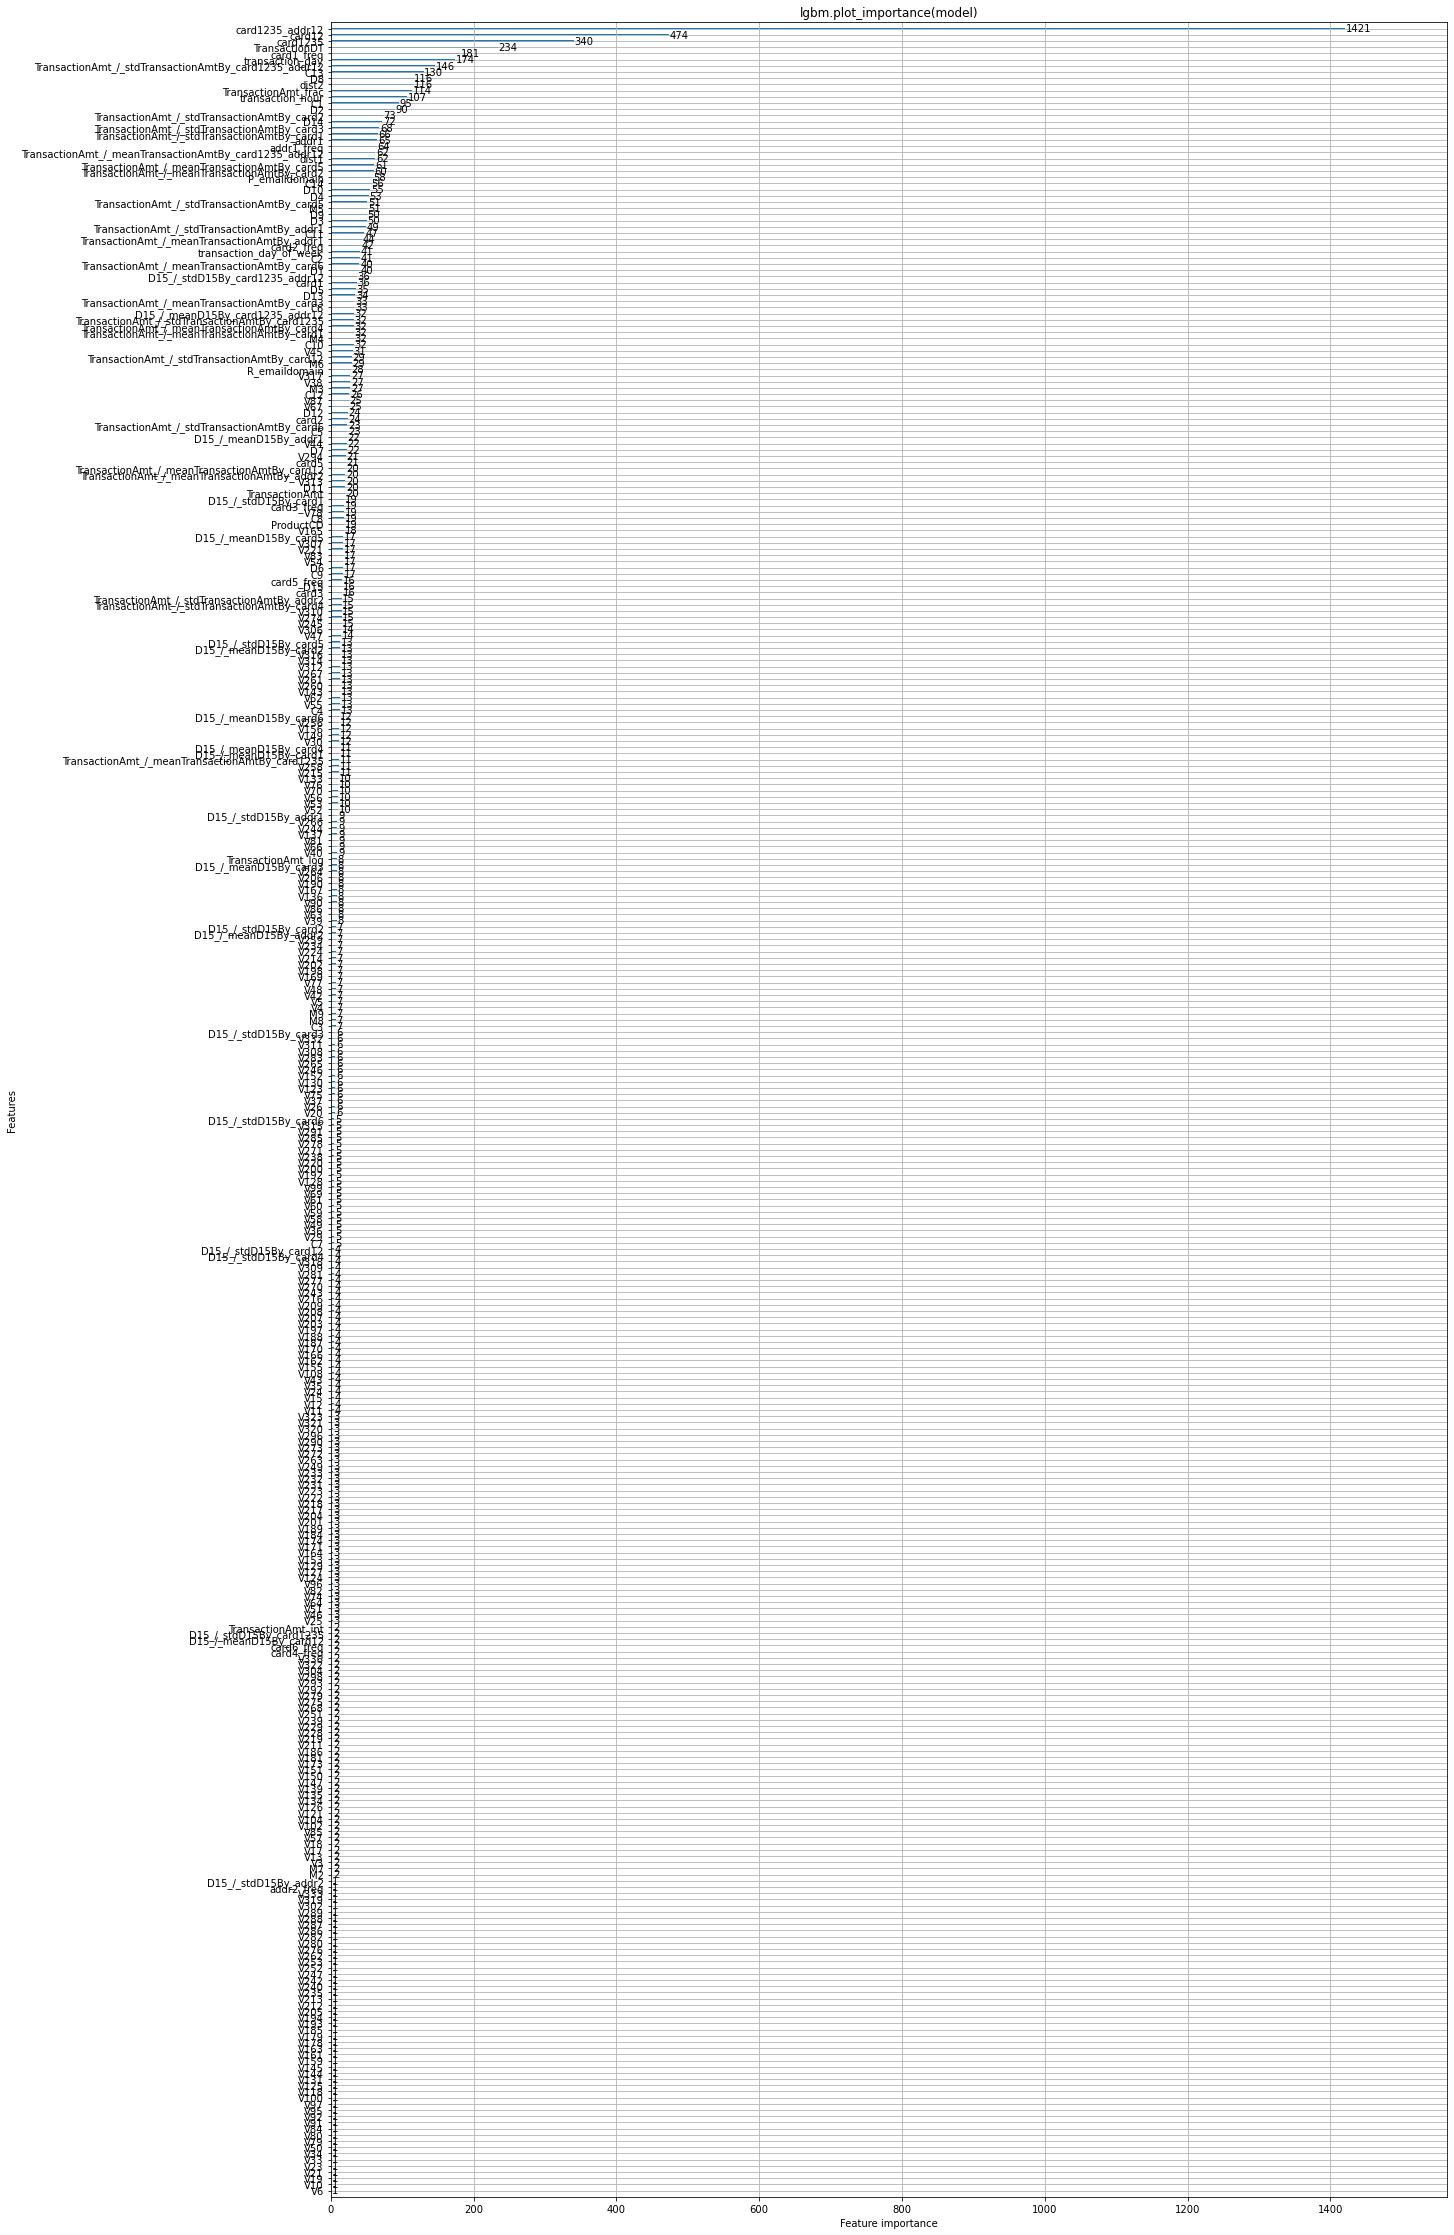

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 40))
lgbm.plot_importance(model, ax=ax)
plt.title("lgbm.plot_importance(model)")
plt.show()

In [14]:
feature_importances_df = pd.DataFrame({"feature_name":model.feature_name_ ,
                                       "feature_importances":model.feature_importances_.tolist()})
feature_importances_df.sort_values('feature_importances', ascending=False)

,feature_name,feature_importances
399,card1235_addr12,1421
397,card12,474
398,card1235,340
0,TransactionDT,234
400,card1_freq,181
...,...,...
279,V227,0
282,V230,0
288,V236,0
289,V237,0


In [15]:
feature_name_importanse_lt21 = feature_importances_df['feature_name'][feature_importances_df['feature_importances']<21]
feature_name_importanse_lt21

1               TransactionAmt
2                    ProductCD
5                        card3
6                        card4
8                        card6
                ...           
448       D15_/_stdD15By_addr2
449      D15_/_stdD15By_card12
450    D15_/_stdD15By_card1235
452         TransactionAmt_int
454         TransactionAmt_log
Name: feature_name, Length: 384, dtype: object

<p><a name="task_2"></a></p>

### Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [16]:
train_data_drop = train_data.copy()
train_data_drop = train_data_drop.drop(columns = feature_name_importanse_lt21)
test_data_drop = test_data.copy()
test_data_drop = test_data_drop.drop(columns = feature_name_importanse_lt21)

train_data_drop

,TransactionDT,card1,card2,card5,addr1,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C5,C6,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D7,D8,D9,D10,D12,D13,D14,M3,M4,M5,M6,V38,V44,V45,V67,V87,V294,V317,transaction_day,transaction_hour,transaction_day_of_week,card12,card1235,card1235_addr12,card1_freq,card2_freq,addr1_freq,TransactionAmt_/_meanTransactionAmtBy_card1,TransactionAmt_/_meanTransactionAmtBy_card2,TransactionAmt_/_meanTransactionAmtBy_card3,TransactionAmt_/_meanTransactionAmtBy_card4,TransactionAmt_/_meanTransactionAmtBy_card5,TransactionAmt_/_meanTransactionAmtBy_card6,TransactionAmt_/_meanTransactionAmtBy_addr1,TransactionAmt_/_meanTransactionAmtBy_card1235_addr12,TransactionAmt_/_stdTransactionAmtBy_card1,TransactionAmt_/_stdTransactionAmtBy_card2,TransactionAmt_/_stdTransactionAmtBy_card3,TransactionAmt_/_stdTransactionAmtBy_card5,TransactionAmt_/_stdTransactionAmtBy_card6,TransactionAmt_/_stdTransactionAmtBy_addr1,TransactionAmt_/_stdTransactionAmtBy_card12,TransactionAmt_/_stdTransactionAmtBy_card1235,TransactionAmt_/_stdTransactionAmtBy_card1235_addr12,D15_/_meanD15By_addr1,D15_/_meanD15By_card1235_addr12,D15_/_stdD15By_card1235_addr12,TransactionAmt_frac
0,86400,13926,NaN,142.0,315.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,117.0,2,0,5,13926|nan,13926|nan|150.0|142.0,13926|nan|150.0|142.0|315.0|87.0,0.000061,NaN,0.042786,0.354492,NaN,0.488037,0.310547,0.555176,0.403809,0.514648,1.000000,0.409896,NaN,0.315706,0.587949,0.262451,0.287963,0.290306,0.290306,NaN,0.000000,NaN,NaN,0.5000
1,86401,2755,404.0,102.0,325.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,M0,T,T,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2,0,5,2755|404.0,2755|404.0|150.0|102.0,2755|404.0|150.0|102.0|325.0|87.0,0.001245,0.006855,0.080017,0.126343,0.145874,0.206543,0.230103,0.152466,0.171021,0.194092,0.127930,0.070150,0.098572,0.133657,0.099870,0.111145,0.126671,0.070150,0.070150,0.107415,0.000000,0.000000,0.000000,0.0000
2,86469,4663,490.0,166.0,330.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,T,M0,F,F,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2,0,5,4663|490.0,4663|490.0|150.0|166.0,4663|490.0|150.0|166.0|330.0|87.0,0.001428,0.061401,0.046204,0.666016,0.452148,0.420410,0.464111,0.637207,0.532227,0.460938,1.109375,0.691704,0.297852,0.271922,0.457807,0.342285,0.263990,0.691704,0.691704,4.110451,1.749023,5.964844,3.177560,0.0000
3,86499,18132,567.0,117.0,476.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,4.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,M0,T,F,1.0,1.0,1.0,1.0,1.0,38.0,1404.0,2,0,5,18132|567.0,18132|567.0|150.0|117.0,18132|567.0|150.0|117.0|476.0|87.0,0.006599,0.010010,0.017273,0.442871,0.395508,0.356201,0.396729,0.419189,0.451172,0.405273,0.472168,0.310214,0.304199,0.230443,0.304783,0.290039,0.279335,0.310214,0.310214,0.167137,0.728027,0.660645,0.837334,0.0000
4,86506,4497,514.0,102.0,420.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2,0,5,4497|514.0,4497|514.0|150.0|102.0,4497|514.0|150.0|102.0|420.0|87.0,0.000011,0.030838,0.007809,1.250000,0.270508,0.356201,0.396729,0.262695,0.294678,0.367188,1.000000,3.535534,0.166016,0.230443,0.172189,0.191650,0.263081,3.535534,3.535534,NaN,NaN,NaN,NaN,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3958217,1877,310.0,224.0,272.0,12.0,NaN,gmail.com,NaN,2.0,1.0,0.0,5.0,0.0,2.0,0.0,5.0,2.0,20.0,20.0,2.0,0.0,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,F,M1,T,F,1.0,1.0,1.0,1.0,1.0,7.0,474.5,15,19,0,1877|310.0,1877|310.0|150.0|224.0,1877|310.0|150

In [17]:
model_drop, res_1 = run_model(train_data_drop, train_target, test_data_drop, test_target)
res_1

[100]	training's auc: 0.997095	valid_1's auc: 0.951251
[200]	training's auc: 0.999821	valid_1's auc: 0.951907
[300]	training's auc: 0.999989	valid_1's auc: 0.952925
[400]	training's auc: 1	valid_1's auc: 0.953441
[500]	training's auc: 1	valid_1's auc: 0.954912
[600]	training's auc: 1	valid_1's auc: 0.956087
[700]	training's auc: 1	valid_1's auc: 0.956311
[800]	training's auc: 1	valid_1's auc: 0.956498
[900]	training's auc: 1	valid_1's auc: 0.956775
[1000]	training's auc: 1	valid_1's auc: 0.956857


{'cv_results': ['0.7951 +/- 0.159'],
 'roc_auc(valid, test)': [0.9540004642626978, 0.8314230225420153],
 'precision(valid, test)': [0.8668730650154799, 0.0],
 'recall(valid, test)': [0.7329842931937173, 0.0],
 'fscore(valid, test)': [0.7943262411347518, nan]}

<p><a name="task_3"></a></p>

### Задание 3: использовать permutation importance, выполнить задание 1 и 2.

<p><a name="task_4"></a></p>

### Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.

<p><a name="task_5"></a></p>

### Задание 5: использовать shap, выполнить задание 1 и 2.

<p><a name="task_6"></a></p>

### Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.